In [10]:
# System
import sys
sys.path.insert(0, '../analysis_scripts/')

# Math
import numpy as np
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
# colors
import matplotlib.colors as mcolors
fs = 20

# scvi
import anndata
import scanpy as sc


# sklearn
from sklearn.metrics import silhouette_score 


from calculate_metrics import *

In [92]:
# load in data
name = 'extrinsic_20ct_many'
index = 'test'
data_dir = '../../data/simulated_data/'

results_file = open(f'../../results/{name}_results_dict.pickle', 'rb')
results_dict = pickle.load(results_file)
results_file.close()


cell_types = results_dict.pop('Cell Type')
cluster_assignments = np.array([int(ct[2:]) for ct in cell_types])
train_index = results_dict.pop('train_index')
test_index = results_dict.pop('test_index')

if index == 'train':
    index_ = train_index
if index == 'test':
    index_ = test_index


# read in adata and subset to test or train data
adata = anndata.read_loom(data_dir+f'{name}.loom')
adata = adata[index_]
cluster_assignments = cluster_assignments[index_]

# add latent spaces to anndata object
for setup in results_dict.keys():
    adata.obsm[f'X_{setup}'] = results_dict[setup]['X_10'][index_]

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


--------

# Silhouette Score

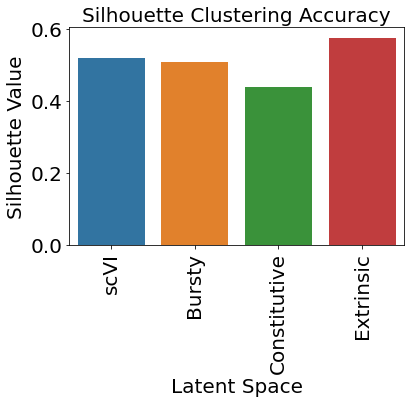

In [93]:
# n samples by n features for ss
ss_dict = {}

setups_to_compare = results_dict.keys()
setup_name_change = {'vanilla.full-10-NAS_SHAPE':'scVI','Bursty-10-NAS_SHAPE': 'biVI','TRUE':'True'}


for setup in setups_to_compare:
    name_ = setup.split('-')[0]
    ss_dict[name_] = [silhouette_score(adata.obsm[f'X_{setup}'], cluster_assignments)]

df_plot = pd.DataFrame(ss_dict).melt()
sns.barplot(data = df_plot,x = 'variable', y ='value')
plt.title('Silhouette Clustering Accuracy',fontsize=fs)
plt.ylabel('Silhouette Value',fontsize=fs)
plt.xlabel('Latent Space',fontsize=fs)
plt.xticks(rotation = 90)
plt.savefig(f'../../results/{name}_figs/silhouette_{index}.png',bbox_inches='tight');

--------------

# Clustering Metrics


In [94]:
def l2_norm(x,y):
    
    a = (x-y)**2
    l2 = np.sqrt(np.sum(a))
    
    return(l2)

def get_intra_cluster_distances(X,cluster_assignments,return_all = False):
    ''' Get distance to cluster mean for each cell.
    -----
    params:
    latent_spaces : np array, size samples x features
    
    cluster_assignments : np array or list, size samples
    
    return_all : return distance to mean of cluster for ALL cells, default FALSE
    
    (if FALSE, returns AVERAGE distance to mean for each cluster assignment)
    -----
    
    returns:
    
    av_distance_to_mean : size n_clusters
    
    cluster_var : variance in av_distance_to_mean, size n_clusters
    
    if return_all == TRUE , also returns distances_to_mean : size # samples
    '''
    
    # declare array to hold all distances
    all_distances = np.zeros(X.shape[0])
    
    # declare array to hold average distances per cluster
    cluster_assignments = np.array(cluster_assignments)
    unique_clusters = np.unique(cluster_assignments)
    
    cluster_distances = np.zeros(len(unique_clusters))
    
    # declare array to hold average variances per cluster
    cluster_variances = np.zeros(len(unique_clusters))
    
    # how many cells have we calculated distances for? 
    cells_finished = 0
    
    # now go through each cluster and calculate distance between mean of that cluster and the vector
    for i,cluster in enumerate(unique_clusters):
        
        # subset to get samples in specific cluster
        X_subset = X[cluster_assignments == cluster]
        
        # take average across all samples in the cluster of the feature values
        cluster_mean = np.mean(X_subset,axis=0)
    
        # find the distance between samples in X_subset and the cluster mean
        distances_ = np.array([l2_norm(vec,cluster_mean) for vec in X_subset])
        
        # append or add distances to distance array
        all_distances[cells_finished : (cells_finished+X_subset.shape[0])] = distances_
        cells_finished += X_subset.shape[0]
        
        # average cluster distance
        cluster_distances[i] = np.mean(distances_)
        
        # variances
        cluster_variances[i] = np.var(distances_)
    
    cluster_variances = cluster_variances[cluster_variances != 0]
    cluster_distances = cluster_distances[cluster_distances != 0]
    all_distances = all_distances[all_distances != 0]
        
    if return_all == True:
        return(cluster_distances,cluster_variances,all_distances)
    
    else:
        return(cluster_distances,cluster_variances)

In [95]:
def get_inter_cluster_distances(X,cluster_assignments):
    ''' Gets distances between all cluster means. 
    --------
    params:
    X : size samples by features
    cluster assignments: clusters of samples in X
    
    -------
    returns:
    inter_cluster_distances : matrix size cluster by cluster of distances between each cluster
    '''
        
        
    cluster_assignments = np.array(cluster_assignments)
    unique_clusters = np.unique(cluster_assignments)
    
    # array to hold mean vectors for each cluster
    cluster_means = np.ones((len(unique_clusters),X.shape[1]))
    
    # array to hold inter cluster distances
    inter_cluster_distances = np.ones((len(unique_clusters),len(unique_clusters)))
    
     # calculate each cluster mean
    for i,cluster in enumerate(unique_clusters):
        
        # subset to get samples in specific cluster
        X_subset = X[cluster_assignments == cluster]
        
        # take average across all samples in the cluster of the feature values
        cluster_mean = np.mean(X_subset,axis=0)
        cluster_means[i,:] = cluster_mean
    
    for i in range(len(unique_clusters)):
        
        for j in range(len(unique_clusters)):
            
            inter_cluster_distances[i,j] = l2_norm(cluster_means[i],cluster_means[j])
            
    return(inter_cluster_distances)

In [96]:

# create a dictionary with the latent spaces 
X_latent = {}

for setup in results_dict.keys():
    X_latent[setup.split('-')[0]] = results_dict[setup]['X_10'][index_]


    
# define dictionary of distances for each model
distance_dict = {ls : {} for ls in X_latent.keys()}
distance_dict_plot = {ls : {} for ls in X_latent.keys()}

In [97]:
for setup in X_latent.keys():
    
    cluster_distances,cluster_variances = get_intra_cluster_distances(X_latent[setup],cluster_assignments)
    inter_cluster_matrix = get_inter_cluster_distances(X_latent[setup],cluster_assignments)
    distance_dict[setup]['Intra-Cluster Distance to Mean'] = cluster_distances
    distance_dict[setup]['Intra-Cluster Variance'] = cluster_variances
    distance_dict[setup]['Inter-Cluster Distance between Means'] = inter_cluster_matrix
    distance_dict[setup]['Fano Factor'] = cluster_variances/cluster_distances 

    
    distance_dict_plot[setup]['Average Intra-Cluster Distance'] = np.mean(cluster_distances)
    distance_dict_plot[setup]['Average Intra-Cluster Variance'] = np.mean(cluster_variances)
    distance_dict_plot[setup]['Average Inter-Cluster Distance'] = np.mean(inter_cluster_matrix[inter_cluster_matrix != 0])
    distance_dict_plot[setup]['Average Fano Factor'] = np.mean(cluster_variances/cluster_distances)

In [98]:
distance_df = pd.DataFrame(distance_dict_plot).transpose

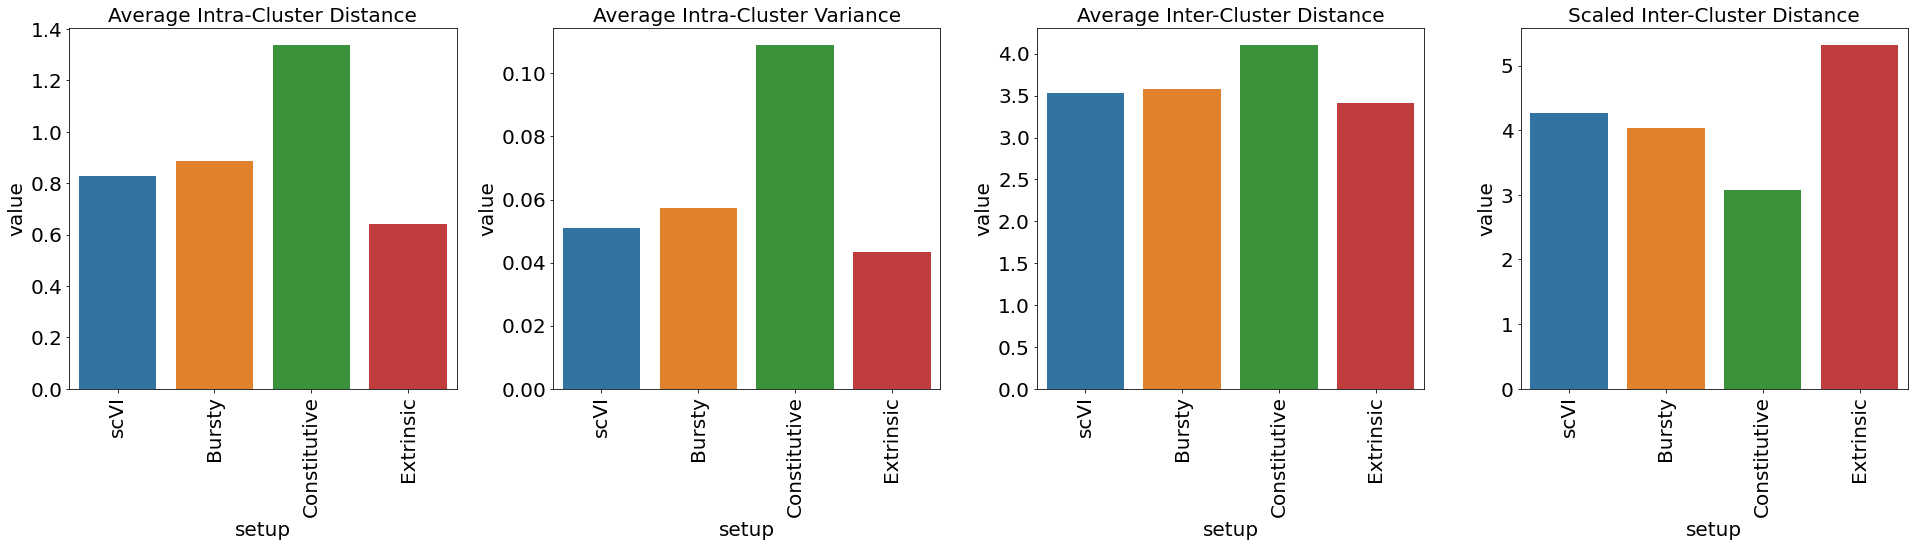

In [99]:
metrics = ['Average Intra-Cluster Distance',
           'Average Intra-Cluster Variance',
           'Average Inter-Cluster Distance']



fig,axes = plt.subplots(1,4,figsize = (27,8))

for i,metric in enumerate(metrics):
    
    dict_plot = {}
    ax = axes[i]
    setups = list(X_latent.keys())
    metric_list = [distance_dict_plot[setup][metric] for setup in setups]
    dict_plot['setup'] = setups
    dict_plot['metric'] = metric_list
    df_plot = pd.DataFrame(dict_plot)
    sns.barplot(ax = ax, data = df_plot, x = 'setup', y ='metric')
    ax.set_title(f'{metric}',fontsize = fs)
    ax.set_ylabel(f'value',fontsize=fs)
    #plt.xlabel('Latent Space Method')
    ax.set_xticklabels(labels = setups, rotation = 90)

ax= axes[i+1]
setups = list(X_latent.keys())
metric_list = [distance_dict_plot[setup]['Average Inter-Cluster Distance']/distance_dict_plot[setup]['Average Intra-Cluster Distance']
               for setup in setups]
dict_plot['setup'] = setups
dict_plot['metric'] = metric_list
df_plot = pd.DataFrame(dict_plot)
sns.barplot(ax = ax, data = df_plot,x = 'setup', y ='metric')
ax.set_title(f'Scaled Inter-Cluster Distance',fontsize = fs)
ax.set_ylabel(f'value',fontsize=fs)
ax.set_xticklabels(labels = setups, rotation = 90, fontsize = fs)
    
plt.tight_layout()
plt.savefig(f'../../results/{name}_figs/clustering_metrics_{index}.png',bbox_inches='tight');

-----------
# Test Reconstruction Error and Timing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


   Train Recon Error  Test Recon Error     Time (s)         Setup  \
0        6168.591375       6434.974812   278.604545          scVI   
1        6117.980971       6378.201248  1564.548737        Bursty   
2        7793.641937       7765.389180   258.767779  Constitutive   
3        5975.371031       6245.775480   299.028278     Extrinsic   

  latent space   Constant  
0           10  NAS_SHAPE  
1           10  NAS_SHAPE  
2           10  NAS_SHAPE  
3           10  NAS_SHAPE  


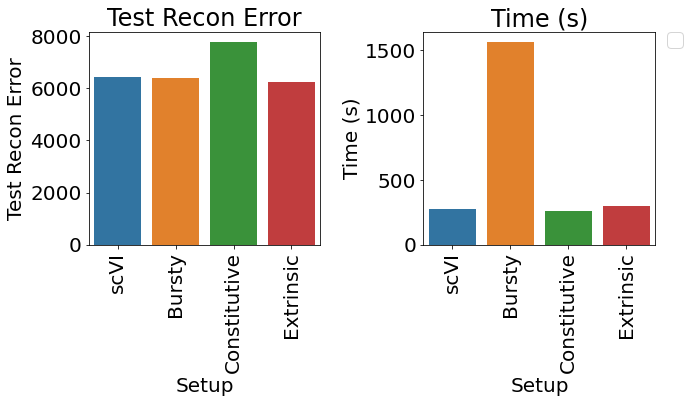

In [100]:
def plot_recon_loss(results_dict,kind):
  setups = list(results_dict.keys())

  df_plot = pd.concat([pd.DataFrame({'Train Recon Error': -1*np.array(item[1]['recon_error'])[0,1]['reconstruction_loss'],
               
                'Test Recon Error': -1*np.array(item[1]['recon_error'])[0,0]['reconstruction_loss'],
               
                'Time (s)': item[1]['runtime'][0],
                'Setup': item[0].split('-')[0],
                'latent space' : item[0].split('-')[1],
                'Constant' : item[0].split('-')[2]},index=[i]) for i,item in enumerate(results_dict.items())])



  fig,axes =plt.subplots(1,len(kind),figsize= (10,6))
  for i,k in enumerate(kind):
      ax = axes[i]
      _ = sns.barplot(data=df_plot, x='Setup', y=k, ax=ax)
      #ax.get_legend().remove()
      ax.set_title(f'{k}')
      ax.set_xticklabels(df_plot.Setup, rotation = 90)
      plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.tight_layout()
  print(df_plot)

  return(df_plot)


plot_recon_loss(results_dict,kind=['Test Recon Error','Time (s)']);
plt.savefig(f'../../results/{name}_figs/recon_error_time_{index}.png',bbox_inches='tight');

---------------

# KLD between Reconstructed and biVI

In [39]:
def plot_CDF(array1,array2,label1,label2,color1):

    cdf1 = np.zeros(len(array1))
    cdf2 = np.zeros(len(array2))
    array1_sorted = np.sort(array1)
    array2_sorted = np.sort(array2)
    for i,value in enumerate(array1_sorted):
        cdf1[i] = len(array1_sorted[array1_sorted<value])/len(array1_sorted)
    for i,value in enumerate(array2_sorted):
        cdf2[i] = len(array2_sorted[array2_sorted<value])/len(array2_sorted)

    plt.plot(array1_sorted,cdf1,label=label1)
    plt.plot(array2_sorted,cdf2,label=label2,color=color1)
    plt.xlabel(f'KL Divergence',fontsize=fs)
    plt.ylabel('Fraction',fontsize=fs)
    plt.title('biVI vs. scVI KL Divergence')
    plt.legend()
       


bursty_20ct_many mean, biVI 0.0149203260320675
bursty_20ct_many mean, scVI 0.21227433908798113


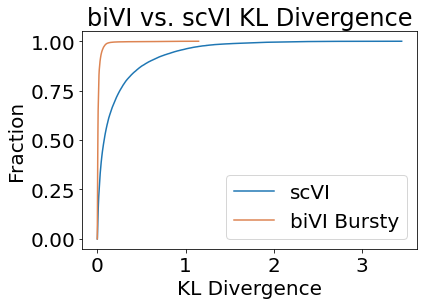

const_20ct_many mean, biVI 0.004698744
const_20ct_many mean, scVI 0.0054895347


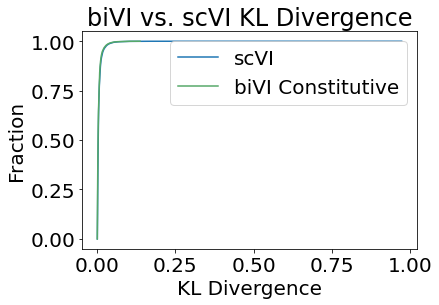

extrinsic_20ct_many mean, biVI 0.0050012427
extrinsic_20ct_many mean, scVI 0.1959421


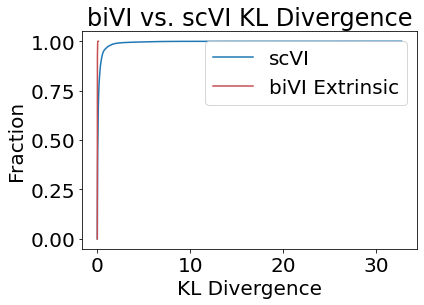

In [41]:
data_sets = ['bursty_20ct_many','const_20ct_many','extrinsic_20ct_many']
dnames = ['Bursty','Constitutive','Extrinsic']
colors = sns.color_palette("deep")[1:4]

for i,dset in enumerate(data_sets):
    
    with open(f'../../results/{dset}_figs/kld_dict.pickle', 'rb') as file:
        kld_dict = pickle.load(file)
        
        dname = dnames[i]
        
        print(f'{dset} mean, biVI',np.mean(kld_dict[f'{dname}-10-NAS_SHAPE']))
        print(f'{dset} mean, scVI',np.mean(kld_dict['scVI-10-NAS_SHAPE']))
        
        plot_CDF(kld_dict['scVI-10-NAS_SHAPE'],kld_dict[f'{dname}-10-NAS_SHAPE'],label1 = 'scVI',
        label2 = f'biVI {dname}',color1 = colors[i])
        plt.savefig(f'../../results/{dset}_figs/KLD_CDF.png',bbox_inches='tight')
        plt.show()